# Diabetes Diagnosis by Classification
Matilda Bae, Chris Tang, Angela Tangonan


## 1. Introduction:
Diabetes is a chronic health condition affecting millions of individuals in the United States and represents a significant public health concern worldwide. The immediate cause of diabetes is a disruption in the body’s ability to either produce or respond effectively to insulin, and poses increased risks for major health complications requiring lifelong management (Diabetes Canada). Approximately 11% of the American population suffers from diabetes today and its prevalence is expected to rise in the coming decades due to a myriad number of factors, including sedentary lifestyles, unhealthy dietary habits, and an aging population (Diabetes Health Indicators Dataset). Investigating the risk factors for diabetes can help drive efforts to identify individuals at risk and tailor preventative strategies specifically for these groups. 

The Diabetes Health Indicators Dataset (2015) contains a valuable trove of data collected through the Behavioural Risk Factor Surveillance System, a national telephone survey that is conducted annually by the Centre for Disease Control and collects responses from over 400,000 Americans relating to health outcomes across the US. Our aim is to develop an accurate classification model for diabetes using these data, and to pinpoint the variables in our survey response data with the greatest impact in predicting diabetes. To this end, we created a random forest classification model that predicted diabetes using ten selected variables with an accuracy of over 70%, and determined that the most important variables in generating our predictive model was an individual's history of blood pressure, their self-reported estimate for their general well-being, and their body mass index.


## 2. Methods & Results

### Data Pre-Processing and Inspection

All data used in this project were sourced from the Diabetes Health Indicators Dataset, assembled from the Behavioural Risk Factor Surveillance System and hosted on Kaggle <citation>. These data contain over 70,000 cleaned and class-balanced observations across 22 variables, selected by the author from telephone data containing 330 features and collected on a total of 441,455 individuals in the original dataset. The author-selected variables contain various demographic and clinical data from survey respondents with and without diabetes, as well as several self-reported measures for expressing their physical well-being. 

The decompressed Kaggle data were uploaded onto our GitHub repository, from where they were retrieved for all further downstream processing. All twenty-one variables were refactored, recoded, and cleaned where appropriate. All instances of a respondent in the data will now be synonymously referred to as “cases”, and all instances of a respondent without diabetes as “controls”.



In [1]:
# Loading in Libraries
rm(list = ls())
library(tidyverse)
library(tidymodels)
library(ranger)
library(janitor)
library(vip)


# Loading in Data
url <- 'https://github.com/MatildaBae/dsci-100-2023W1-group45/raw/main/data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
diab_data <- read_csv(url)


# Formatting column classes appropriately
age_levels <- c('[18,24]', 
                '[25,29]', 
                '[30,34]', 
                '[35,39]', 
                '[40,44]', 
                '[45,49]', 
                '[50,54]', 
                '[55,59]', 
                '[60,64]', 
                '[65,69]', 
                '[70,74]', 
                '[75,79]', 
                '[79,∞)')

diab_data <- diab_data %>% 
        mutate(across(everything(), as_factor)) %>%
        mutate(Diabetes_binary = fct_recode(Diabetes_binary, 'Case' = '1', 'Control' = '0')) %>%
        mutate(Diabetes_binary = factor(Diabetes_binary, levels = c('Case', 'Control'))) %>%
        mutate(Sex = fct_recode(Sex, 'Female' = '0', 'Male' = '1')) %>%
        mutate(Sex = factor(Sex, levels = c('Male', 'Female'))) %>%
        mutate(Age = fct_recode(Age, 
                                '[18,24]' = '1',
                                '[25,29]' = '2',
                                '[30,34]' = '3',
                                '[35,39]' = '4',
                                '[40,44]' = '5',
                                '[45,49]' = '6',
                                '[50,54]' = '7',
                                '[55,59]' = '8',
                                '[60,64]' = '9',
                                '[65,69]' = '10',
                                '[70,74]' = '11',
                                '[75,79]' = '12',
                                '[79,∞)' = '13')) %>%
        mutate(Age = factor(Age, levels = age_levels)) %>%
        mutate(BMI = as.numeric(BMI),
               MentHlth = as.numeric(MentHlth),
               GenHlth = as.numeric(GenHlth)) %>%
        clean_names()


# Examining data
glimpse(diab_data)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Rows: 70,692
Columns: 22
$ diabetes_binary        <fct> Control, Control, Control, Control, Control, Co…
$ high_bp                <fct> 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,…
$ high_chol              <fct> 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,…
$ chol_check             <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ bmi                    <dbl> 15, 15, 15, 17, 18, 7, 15, 20, 21, 16, 13, 10, …
$ smoker                 <fct> 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,…
$ stroke                 <fct> 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ heart_diseaseor_attack <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,…
$ phys_activity          <fct> 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,…
$ fruits                 <fct> 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ veggies                <fct> 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,…
$ hvy_alcohol_consump    <fct> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ any_healthcar

We can see in the above printout that there are indeed just over 70,000 observations, spread across 22 variables. Many of these are encoded as factor variables, likely the answers given to yes-or-no questions posed to survey respondents. Some of these appear to be bins e.g., age, representing the discrete interval in which the actual value is contained. For a detailed codebook of each variable, please refer to the Behavioural Risk Factor Surveillance System dataset as hosted on Kaggle CITE THIS CITE THIS CITE THIS.


In [2]:
# Examining dataset for NA values
diab_data %>% summarize(across(-diabetes_binary, ~ sum(is.na(.))))
print("Table 1. Missing data across variables in dataset")


# Class breakdown
diab_data %>% group_by(diabetes_binary) %>% summarize(count = n())
print("Table 2. Number of cases-controls in dataset")

high_bp high_chol chol_check bmi smoker stroke heart_diseaseor_attack
1 0       0         0          0   0      0      0                     
  phys_activity fruits veggies ⋯ any_healthcare no_docbc_cost gen_hlth
1 0             0      0       ⋯ 0              0             0       
  ment_hlth phys_hlth diff_walk sex age education income
1 0         0         0         0   0   0         0

[1] "Table 1. Missing data across variables in dataset"


diabetes_binary count
1 Case            35346
2 Control         35346

[1] "Table 2. Number of cases-controls in dataset"


There are no NA values in these data (table). Thus, these data have been entirely cleaned and contain only comprehensive answers. The dataset contains an even number of cases and controls (table 2), meaning that we will not have to employ any over- or undersampling techniques to correct any class imbalances

Before proceeding any further with our data exploration, we will split our dataset into training and test subsets to ensure that whatever decisions we make using these data, decisions which will eventually be used to guide our model creation, will come solely from the training data. 

Given that the primary computational bottleneck in random forest modeling is the training step, we will limit the size of the training set to 500 observations for computational expediency. The remaining 70192 will be reserved for the test set.


In [3]:
# Splitting data into training-testing subsets (500 training observations, remainder are test)
set.seed(123)
diab_split <- diab_data %>%
        initial_split(prop = 0.00707293612,
                      strata = diabetes_binary)
diab_train <- diab_split %>%
        training()
diab_test <- diab_split %>%
        testing()

### Exploratory Data Analysis

Before we proceed with any form of modeling, we should first examine our dataset for any meaningful patterns and make a determination about which variables we should include in our eventual model.

The association between diabetes and obesity is well-documented, to the extent that there exists a term to describe this link: "diabesity" (CITE THIS CITE THIS CITE THIS https://www.nature.com/articles/s41569-020-00465-5). We will start by examining the body mass indices (BMI) of cases and controls.

Warning message:
“Removed 4 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


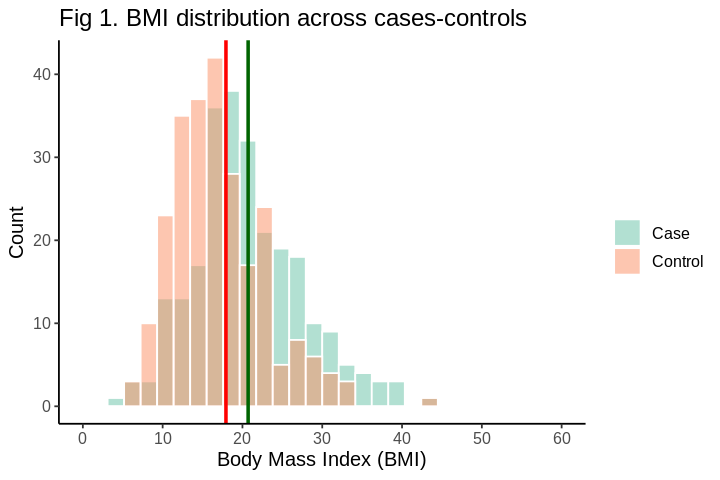

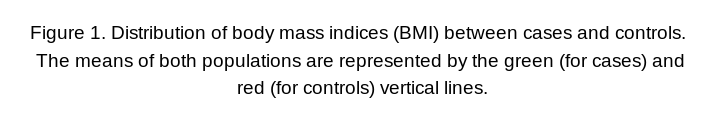

In [4]:
# BMI summary statistics
summary_bmi <- diab_train %>% 
  select(diabetes_binary, bmi) %>%
  group_by(diabetes_binary) %>%
  summarize(mean_bmi = mean(bmi),
            sd_bmi = sd(bmi))


# Plot settings
options(repr.plot.width = 6, 
        repr.plot.height = 4)

# Plotting BMI frequency
mean_bmi_case <- summary_bmi %>% 
        filter(diabetes_binary == 'Case') %>% 
        pull(mean_bmi)

mean_bmi_control <- summary_bmi %>% 
        filter(diabetes_binary == 'Control') %>% 
        pull(mean_bmi)

bmi_plot <- diab_train %>%
  ggplot(aes(x = bmi, fill = diabetes_binary)) +
  geom_histogram(bins = 30, 
                 color = 'white',
                 linewidth = 0.5,
                 alpha = 0.5,
                 position = 'identity') +
  geom_vline(xintercept = mean_bmi_case, color = 'darkgreen', linewidth = 1) +
  geom_vline(xintercept = mean_bmi_control, color = 'red', linewidth = 1) +
  scale_x_continuous(limits = c(0, 60),
                     breaks = seq(0, 60, 10)) +
  labs(x = 'Body Mass Index (BMI)', 
       y = 'Count',
       fill = '') +
  ggtitle('Fig 1. BMI distribution across cases-controls') +
  scale_fill_brewer(palette = 'Set2') +
  theme_classic() +
  theme(text = element_text(size = 12))
bmi_plot


# Figure 1 caption
options(repr.plot.width = 6, 
        repr.plot.height = 1)
fig1 <- paste('Figure 1. Distribution of body mass indices (BMI) between cases and controls. \n The means of both populations are represented by the green (for cases) and \n red (for controls) vertical lines.')
ggplot() + 
  annotate("text", x = 0, y = 0, size = 4, label = fig1) + 
  theme_void()

This distribution plot demonstrates that cases (mean given by red line) tend to have a higher BMI compared to cases (mean given by green line). This aligns with the existing consensus on diabesity, which asserts that an elevated BMI is associated with an increased likelihood of diabetes CITE THIS CITE THIS.

Next, we will examine the gen_hlth and ment_hlth variables. gen_hlth records each respondent's self-reported score on their general well-being, with scores ranging from 1 (excellent) to 5 (poor). ment_hlth records the number of days in the past month that each respondent's mental health was not good.



`summarise()` has grouped output by 'diabetes_binary'. You can override using
the `.groups` argument.
Warning message in geom_histogram(stat = "identity", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


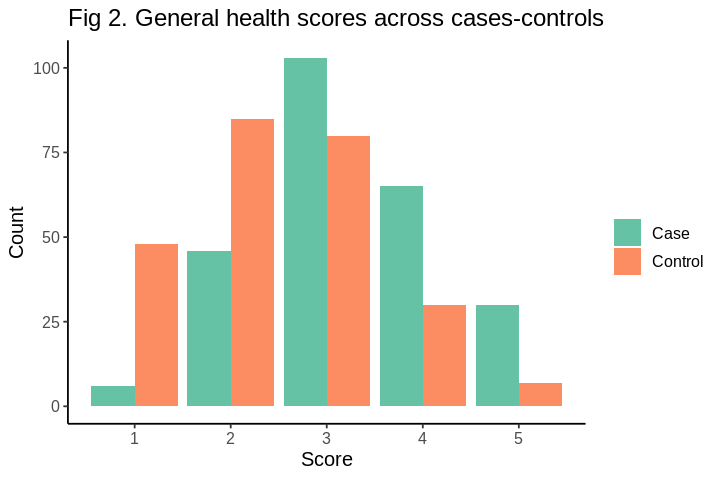

`summarise()` has grouped output by 'diabetes_binary'. You can override using
the `.groups` argument.
Warning message in geom_histogram(stat = "identity", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


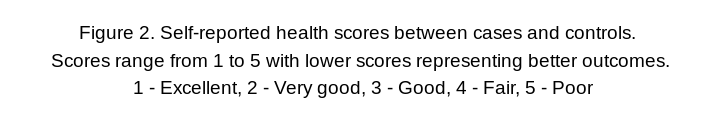

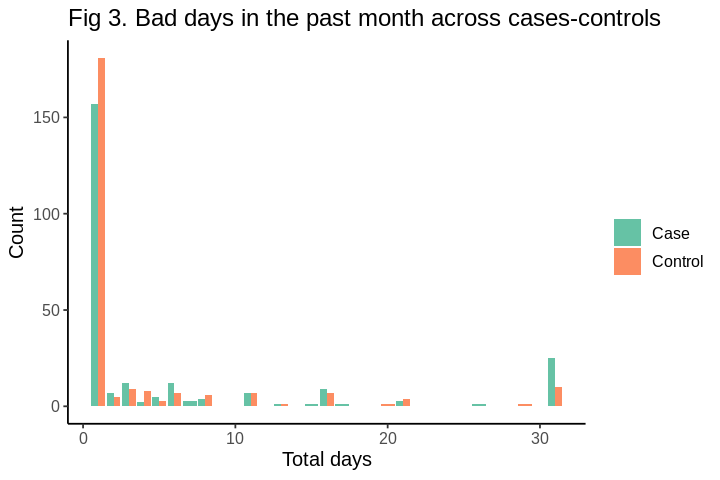

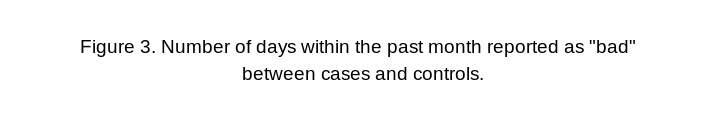

In [5]:
# General health distribution
options(repr.plot.width = 6, 
        repr.plot.height = 4)

gen_plot <-
        diab_train %>% 
        select(diabetes_binary, gen_hlth) %>%
        group_by(diabetes_binary, gen_hlth) %>%
        summarize(count = n()) %>%
        ggplot(aes(x = gen_hlth, 
                   y = count,
                   fill = diabetes_binary)) +
        geom_histogram(stat = 'identity', position = 'dodge') +
        labs(x = 'Score', 
             y = 'Count',
             fill = '') +
        ggtitle('Fig 2. General health scores across cases-controls') +
        scale_fill_brewer(palette = 'Set2') +
        theme_classic() +
        theme(text = element_text(size = 12))
gen_plot


# Figure 2 caption
options(repr.plot.width = 6, 
        repr.plot.height = 1)
fig2 <- paste('Figure 2. Self-reported health scores between cases and controls. \n Scores range from 1 to 5 with lower scores representing better outcomes. \n 1 - Excellent, 2 - Very good, 3 - Good, 4 - Fair, 5 - Poor')
ggplot() + 
  annotate("text", x = 0, y = 0, size=4, label = fig2) + 
  theme_void()


# Mental health distibution
options(repr.plot.width = 6, 
        repr.plot.height = 4)
ment_plot <- 
        diab_train %>% 
        select(diabetes_binary, ment_hlth) %>%
        group_by(diabetes_binary, ment_hlth) %>%
        summarize(count = n()) %>%
        ggplot(aes(x = ment_hlth, 
                   y = count,
                   fill = diabetes_binary)) +
        geom_histogram(stat = 'identity', position = 'dodge')  +
        labs(x = 'Total days', 
             y = 'Count',
             fill = '') +
        ggtitle('Fig 3. Bad days in the past month across cases-controls') +
        scale_fill_brewer(palette = 'Set2') +
        theme_classic() +
        theme(text = element_text(size = 12))
ment_plot


# Figure 3 caption
options(repr.plot.width = 6, 
        repr.plot.height = 1)
fig3 <- paste('Figure 3. Number of days within the past month reported as "bad" \n between cases and controls.')
ggplot() + 
  annotate("text", x = 0, y = 0, size=4, label = fig3) + 
  theme_void()

We can see that controls tend to report scores of 1 and 2 (excellent to very good) more so than cases do (figure 2). Conversely, cases tend to report scores of 3 to 5 (good to poor) more so than controls do. 

With respect to the mental health data (figure 3), most respondents reported less than ten bad days in the past month for both cases and controls. However, we can see that twice as many number of cases compared to controls reported that every day in their past month was bad.

Next, we will examine the age and sex data. Increased age has been demonstrated to correlate with a greater risk of diabetes. In addition, this heightened risk is thought to be distributed unevenly between men and women across different populations. It is a common practice to depict age and sex data in tandem through the use of a pyramid plot, which we will do here.







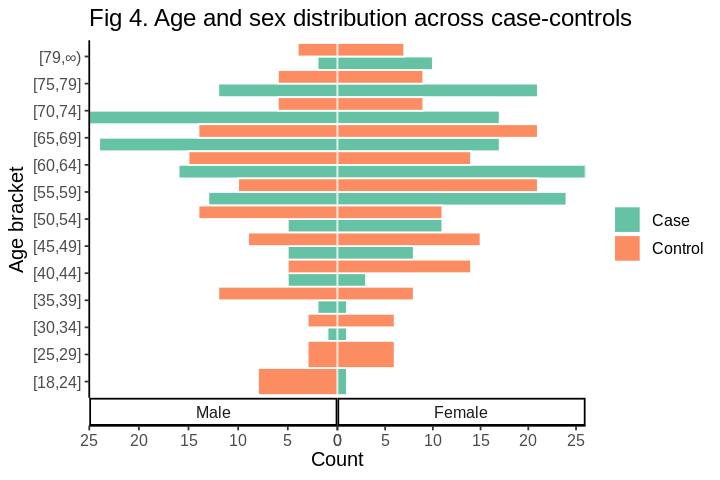

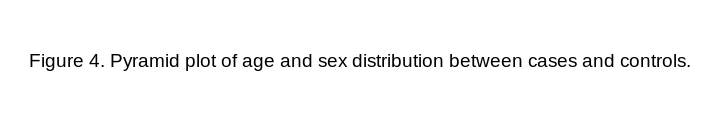

In [6]:
# Population plot
options(repr.plot.width = 6, 
        repr.plot.height = 4)
diab_train %>% 
  count(diabetes_binary, 
        age, 
        sex) %>%
  mutate(n = ifelse(sex == 'Male', 
                    n * -1, 
                    n)) %>%
  ggplot(aes(x = age, 
             y = n, 
             fill = diabetes_binary)) +
  geom_bar(stat = 'identity', 
           position = 'dodge',
           color = 'white',
           width = 1) +
  labs(x = 'Age bracket', 
       y = 'Count',
       fill = '') +
  ggtitle('Fig 4. Age and sex distribution across case-controls') +
  coord_flip() +
  scale_fill_brewer(palette = 'Set2') +
  theme_classic() +
  scale_y_continuous(labels = abs,
                     expand = c(0,0)) +
  facet_wrap(~sex, 
             strip.position = 'bottom', 
             scale = 'free_x') +
  theme(text = element_text(size = 12), 
        panel.spacing.x = unit(0, 'pt'))


# Figure 4 caption
options(repr.plot.width = 6, 
        repr.plot.height = 1)
fig4 <- paste('Figure 4. Pyramid plot of age and sex distribution between cases and controls.')
ggplot() + 
  annotate("text", x = 0, y = 0, size=4, label = fig4) + 
  theme_void()

We can see that most survey respondents in our dataset are between 60 to 70 years old (figure 4). Few to no respondents aged 18 to 30 had diabetes - respondents were more likely to have diabetes the older they were. The data do not reveal an immediately evident connection between sex and diabetes, although there might be interactions between age, sex, and diabetes that are not readily apparent in this plot alone.

Lastly, we will explore the binary answer survey data i.e., the data encoding answers in which respondents were to simply respond "yes" or "no" for a number of questions relating to their health and lifestyle.






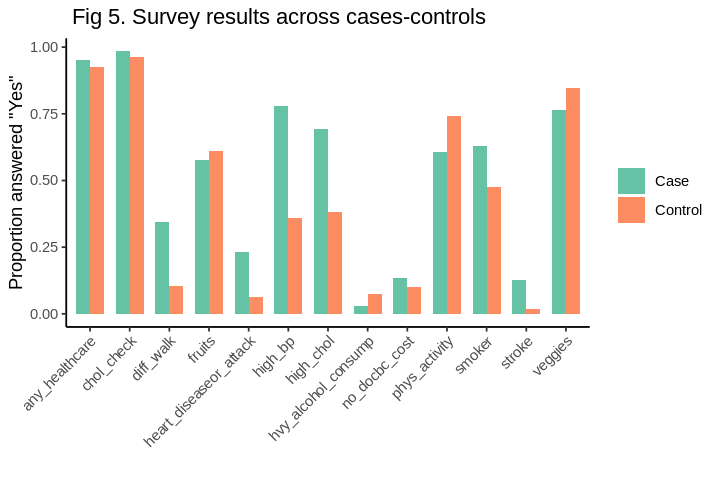

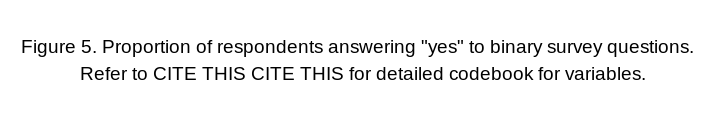

In [7]:
# Looking at binary survey data
options(repr.plot.width = 6, 
        repr.plot.height = 4)
diab_summary <- diab_train %>% 
  select(-sex) %>%
  group_by(diabetes_binary) %>% 
  summarize(across(where(~ is.factor(.x) && length(unique(.x)) == 2), ~ sum(. == "1") / n(), .names = '{.col}'))

survey_plot <- diab_summary %>%
  pivot_longer(!diabetes_binary) %>%
  ggplot(aes(x = name, y = value, fill = diabetes_binary)) +
  geom_bar(stat = 'identity', position = 'dodge', width = 0.7) +
  labs(x = '', y = 'Proportion answered "Yes"', fill = '') +
  ggtitle(" Fig 5. Survey results across cases-controls") +
  scale_fill_brewer(palette = 'Set2') +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
survey_plot


# Figure 5 caption
options(repr.plot.width = 6, 
        repr.plot.height = 1)
fig5 <- paste('Figure 5. Proportion of respondents answering "yes" to binary survey questions. \n Refer to CITE THIS CITE THIS for detailed codebook for variables.')
ggplot() + 
  annotate("text", x = 0, y = 0, size=4, label = fig5) + 
  theme_void()

In these data, we observe some divergence between cases and controls (figure 5). Cases were more likely to answer "yes" when asked if they have high blood pressure (high_bp), high cholesterol (high_chol), difficulty ambulating (diff_walk), whether they have smoked more than a hundred total cigarettes in their lifetime (smoker), or whether they have had a history of heart disease or heart attacks (heart_diseaseor_attack) compared to controls. Cases were also less likely to report having done any physical activity or exercise during the past 30 days outside of their job (phys_activity).

In summary, we have visualized some potentially meaningful differences between cases and controls in these data. These findings align with a common understanding about diabetes. For example, it is reasonable to expect that individuals with diabetes may also have a history of high blood pressure and elevated cholesterol levels CITE THIS CITE THIS. Altogether, the variables we have individually identified in this section (BMI, general and mental health scores, age, sex, and history of high blood pressure, high cholesterol, heart disease, difficulty walking, and smoking status) have the potential to serve as valuable predictors in our eventual classification model.

### Principal Component Analysis
Before making a final determination on feature selection, it is good practice to visualize their distributions together as a whole. However, plotting 21 variables would involve displaying it in 21 dimensions, which is impractical.

As an alternative approach, we employed Principal Component Analysis (PCA), a statistical technique used for dimensionality reduction which condenses the information from the original variables into a smaller number of unitless principal components. This allows a dataset containing multiple variables to be more intuitively visualized.

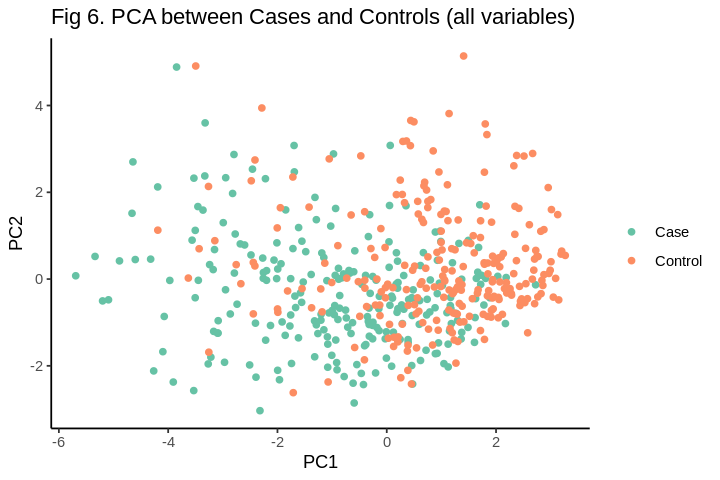

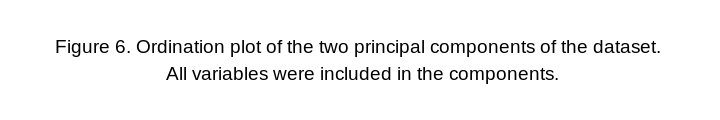

In [8]:
# Change factor variables into numeric for visualization
factor_cols_all <- sapply(diab_train, is.factor)

diab_vis_all <- diab_train %>%
  mutate_if(factor_cols_all, as.integer)

selected_numeric_all <- diab_vis_all[, factor_cols_all]
selected_numeric_all <- selected_numeric_all - 1

diab_vis_all[, factor_cols_all] <- selected_numeric_all


# Perform PCA
pca_all <- prcomp(diab_vis_all[, -which(names(diab_vis_all) == 'diabetes_binary')], 
                  scale. = TRUE)


# Extract the first two principal components
pca_data_all <- as.data.frame(pca_all$x[, 1:2])
colnames(pca_data_all) <- c("PC1", "PC2")


# Add target variable for coloring
pca_data_all$diabetes_binary <- diab_train$diabetes_binary


# Plot using ggplot
options(repr.plot.width = 6, 
        repr.plot.height = 4)
pca_vis_all <- ggplot(aes(x=PC1, y=PC2, color=diabetes_binary), 
                           data = pca_data_all) +
  geom_point() +
  scale_color_brewer(palette = 'Set2') +
  ggtitle("Fig 6. PCA between Cases and Controls (all variables)") +
  labs(color = '') +
  theme_classic()

pca_vis_all


# Figure 6 caption
options(repr.plot.width = 6, 
        repr.plot.height = 1)
fig6 <- paste('Figure 6. Ordination plot of the two principal components of the dataset. \n All variables were included in the components.')
ggplot() + 
  annotate("text", x = 0, y = 0, size=4, label = fig6) + 
  theme_void()

We can see some evidence for clustering in both cases and controls, although there is still some significant overlap between the two groups (figure 6). To check whether our ten selected predictors made the clustering any less or more clearer, we performed the same PCA method with the selected columns. 

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(col)

  # Now:
  data %>% select(all_of(col))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


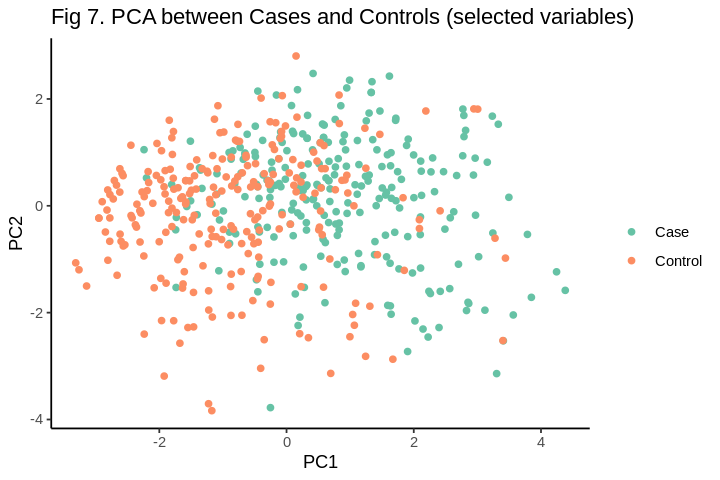

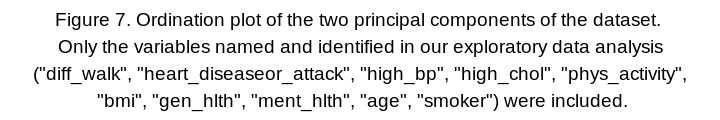

In [9]:
# Select 9 variables by observing plots from each variables
col <- c("diabetes_binary","diff_walk", "heart_diseaseor_attack", "high_bp", "high_chol", "phys_activity", "bmi", "gen_hlth", "ment_hlth", "age", "smoker") 

diab_sel <- diab_train %>%
  select(col)


# Change factor variables into numeric for visualization
factor_cols <- sapply(diab_sel, is.factor)

diab_vis <- diab_sel %>%
  mutate_if(factor_cols, as.integer)

selected_numeric <- diab_vis[, factor_cols]
selected_numeric <- selected_numeric - 1

diab_vis[, factor_cols] <- selected_numeric


# Visualize data in 2-dimensions plot
# Perform PCA
pca <- prcomp(diab_vis[, -which(names(diab_vis) == 'diabetes_binary')], scale. = TRUE)


# Extract the first two principal components
pca_data <- as.data.frame(pca$x[, 1:2])
colnames(pca_data) <- c("PC1", "PC2")


# Add target variable for coloring
pca_data$diabetes_binary <- diab_train$diabetes_binary


# Plot using ggplot
options(repr.plot.width = 6, 
        repr.plot.height = 4)
pca_vis <- ggplot(aes(x=PC1, y=PC2, color=diabetes_binary), data = pca_data) +
  geom_point() +
  scale_color_brewer(palette = 'Set2') +
  ggtitle("Fig 7. PCA between Cases and Controls (selected variables)") +
  labs(color= "") +
  theme_classic()

pca_vis


# Figure 7 caption
options(repr.plot.width = 6, 
        repr.plot.height = 1)
fig7 <- paste('Figure 7. Ordination plot of the two principal components of the dataset. \n Only the variables named and identified in our exploratory data analysis \n ("diff_walk", "heart_diseaseor_attack", "high_bp", "high_chol", "phys_activity", \n "bmi", "gen_hlth", "ment_hlth", "age", "smoker") were included.')
ggplot() + 
  annotate("text", x = 0, y = 0, size=4, label = fig7) + 
  theme_void()

This visualization indicates that the level of divergence between the two clusters does not change very much regardless of whether we choose to incorporate all variables in these data, or whether we aim to include only the ten we identified through our exploratory data analysis (figure 7). Consequently, we anticipate that removing the other ten variables will likely not have a significant impact on the performance of our eventual classification model, and will also expedite the training process.  As an aside, component 1 seems to be the most informative in resolving cases versus controls, with a positive score being associated with cases and a negative score being associated with controls.

To visualize the relationships between the ten variables we selected and to better inspect their significance, we examined their loadings through a loading plot. In a loading plot, each feature is represented by a vector, and the alignment of these vectors signifies the correlation between the original variables and the principal components. Features that align with one another, either in the same or opposite direction, are strongly correlated or anti-correlated with one another respectively. The length of the vectors reflects the strength of the relationship, with a longer arrow indicating a higher contribution to the corresponding component.

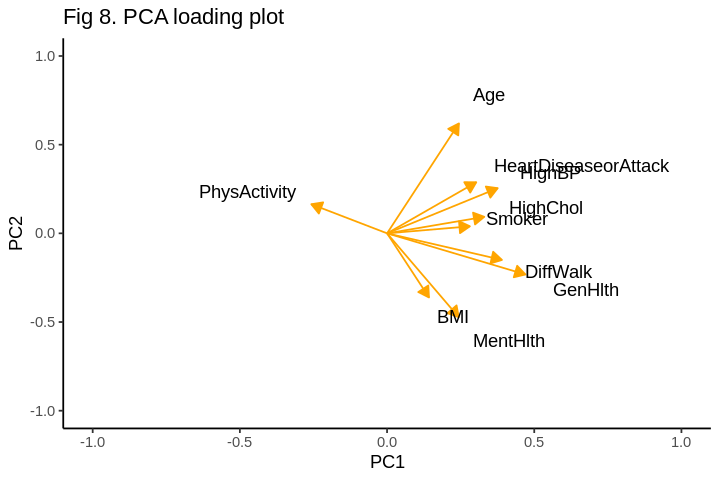

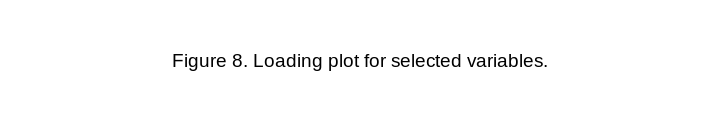

In [10]:
# Create a data frame for plotting the loading vectors
loading_plot <- data.frame(
  Variable = colnames(pca$rotation),
  PC1 = pca$rotation[, 1],  # PC1 loadings
  PC2 = pca$rotation[, 2]   # PC2 loadings
)

new_row_names <- c("DiffWalk", "HeartDiseaseorAttack", "HighBP", " HighChol", 
                   "PhysActivity", "BMI", "GenHlth", "MentHlth", "Age", "Smoker")
loading_plot$Variable <- new_row_names

# Plot the PCA loading plot with arrows
options(repr.plot.width = 6, 
        repr.plot.height = 4)
pca_load <- ggplot(loading_plot, aes(x = 0, y = 0, xend = PC1, yend = PC2)) +
  geom_segment(arrow = arrow(type = "closed", length = unit(0.1, "inches")), color = "orange") +
  geom_text(aes(label = Variable, x = PC1 * 1.2, y = PC2 * 1.2), 
            hjust = ifelse(loading_plot$PC1 > 0, 0, 1),  # Adjust horizontal position
            vjust = ifelse(loading_plot$PC2 > 0, 0, 1)) +
  xlim(-1, 1) + ylim(-1, 1) +
  labs(x = "PC1", y = "PC2", title = "Fig 8. PCA loading plot") +
  theme_classic()

pca_load


# Figure 8 caption
options(repr.plot.width = 6, 
        repr.plot.height = 1)
fig8 <- paste('Figure 8. Loading plot for selected variables.')
ggplot() + 
  annotate("text", x = 0, y = 0, size = 4, label = fig8) + 
  theme_void()

In this loading plot (figure 8), we can see that physical activity has a negative loading on component 1, whereas every other variable seems to have a positive loading for component 1. As component 1 is where we see the most divergence between cases and controls, and a negative score is associated with  this aligns with what we might expect: that people without diabetes are more likely to perform regular physical activity.



### Random Forest

Random Forest is a machine learning tool that creates a multitude of decision trees during training. Each tree in the ensemble makes an individual prediction and the final prediction is determined by a majority vote among all the trees. In the context of predicting diabetes, Random Forest can be valuable due to its ability to handle multidimensional datasets and determining feature importance. By considering multiple decision trees and aggregating their predictions, Random Forest can potentially provide a robust and accurate model for predicting diabetes using the variables we have, while giving us a readout of which variables are most important in determining its predictions.


Having selected ten predictors to incorporate into our random forest model, we first employed a cross-validation approach to tune two hyperparameters in our eventual model: the number of variables randomly chosen at each split (mtry), and the minimum threshold of samples at which to cease splitting (min_n). All numeric data were z-scored transformed, and all factor variables transformed into dummy variables, prior to modeling.

In [11]:
# Selecting features for training and test set
diab_train <- diab_train %>%
  select(col)
diab_test <- diab_test %>%
  select(col)


# Setting up folds for cross-validation
set.seed(123)

diab_cv <- diab_train %>% 
  vfold_cv(v = 10, strata = diabetes_binary)

# Setting up recipe
diab_recipe <- recipe(diabetes_binary ~ ., diab_sel) %>%
  step_normalize(all_numeric_predictors()) %>%
  step_dummy(all_factor_predictors())


# Setting up model specification, tuning mtry and min_n hyperparameters
cv_spec <- rand_forest(mtry = tune(), 
                       min_n = tune(),
                       trees = 501) %>%
  set_engine('ranger', seed = 123) %>%
  set_mode('classification')


# Setting up workflow object
cv_workflow <- workflow() %>%
  add_recipe(diab_recipe) %>%
  add_model(cv_spec)

After creating the cross-validation workflow object, we set up various permutations of mtry and min_n to test, performed 10-fold cross-validation, and inspected the mean accuracies calculated by each different pair of hyperparameters.

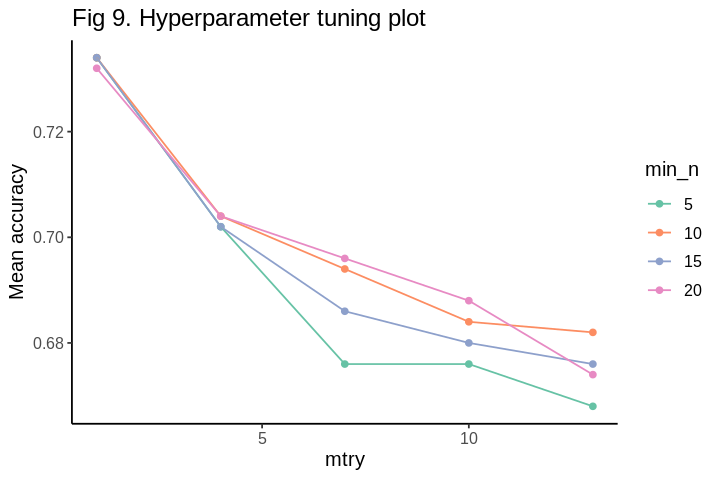

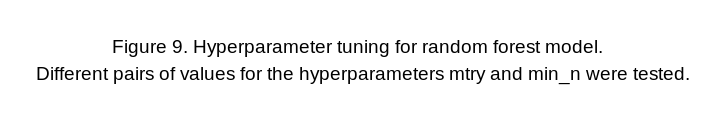

In [12]:
# Pairs of mtry, min_n values to try
tune_grid <- tibble(mtry = rep(seq(to=13, by=3), each = 4),
                    min_n = rep(seq(from = 5, to = 20, by = 5), 5))

# 10-fold cross-validation
set.seed(123)

cv_results <- cv_workflow %>% 
  tune_grid(resamples = diab_cv, grid = tune_grid) %>%
  collect_metrics()


# Inspecting cross-validation results
cv_params <- cv_results %>% 
  filter(.metric == 'accuracy') %>% 
  select(mtry, min_n, mean) %>%
  arrange(desc(mean))


# Hyperparameter performance plot

options(repr.plot.width = 6, 
        repr.plot.height = 4)

param_plot <- cv_params %>%
  ggplot(aes(x = mtry, 
             y = mean, color = factor(min_n))) +
           geom_point() +
           geom_line() +
  labs(y = 'Mean accuracy', color = 'min_n') +
  ggtitle('Fig 9. Hyperparameter tuning plot') +
  scale_color_brewer(palette = 'Set2') +
  theme_classic() +
  theme(text = element_text(size = 12))
param_plot


# Figure 9 caption
options(repr.plot.width = 6, 
        repr.plot.height = 1)
fig9 <- paste('Figure 9. Hyperparameter tuning for random forest model. \n Different pairs of values for the hyperparameters mtry and min_n were tested.')
ggplot() + 
  annotate("text", x = 0, y = 0, size = 4, label = fig9) + 
  theme_void()


# Pulling optimal hyperparameter values
mtry_param <- cv_params %>% 
  slice_head(n = 1) %>% 
  select(mtry) %>% 
  pull()

min_n_param <- cv_params %>% 
  slice_head(n = 1) %>% 
  select(min_n) %>% 
  pull()

In [13]:
cat(paste('Optimal mtry value:' , mtry_param, '\nOptimal min_n value:', min_n_param))

Optimal mtry value: 1 
Optimal min_n value: 5

Lower values of mtry appear to generate models that perform better on the training set. Having determined the optimal mtry and min_n values to use, out of the ones we tested, we then fitted out our final random forest model using these tuned hyperparameters, applied it to our test set, and examined the results.

In [19]:
# Setting up final model specification with tuned parameters
set.seed(123)
rf_spec <- rand_forest(mtry = mtry_param, 
                       min_n = min_n_param, 
                       trees = 501) %>% 
  set_engine('ranger',
             importance = 'impurity', 
             seed = 123) %>%
  set_mode('classification')


# Setting up final workflow, fitting model
rf_wf <- workflow() %>%
  add_model(rf_spec) %>%
  add_recipe(diab_recipe)

rf_fit <- rf_wf %>%
  fit(diab_train)


# Generating predictions on test set, examining results
set.seed(123)
rf_predict <- rf_fit %>%
  predict(diab_test) %>% bind_cols(diab_test)

rf_prob <- rf_fit %>% 
  predict(diab_test, type = 'prob') %>%
  bind_cols(diab_test)

accuracies <-rf_predict %>%
  metrics(truth = diabetes_binary, .pred_class)

rf_predict %>%
  metrics(truth = diabetes_binary, .pred_class) %>%
  bind_rows(rf_predict %>%
              precision(truth = diabetes_binary, estimate = .pred_class), 
            rf_predict %>% 
              recall(truth = diabetes_binary, estimate = .pred_class))
print("Table 3. Performance metrics of random forest model")

.metric   .estimator .estimate
1 accuracy  binary     0.7314366
2 kap       binary     0.4628733
3 precision binary     0.7263354
4 recall    binary     0.7427057

[1] "Table 3. Performance metrics of random forest model"


When tested on our test set of ~70,000 observations, our random forest model accurately predicts the occurence of diabetes approximately 73% of the time. Our sensitivity (sens) and specificity (spec) rates are also over 70%. This indicates that our model captures over 70% of all actual diabetes cases in our dataset, and our of all the respondents predicted to have diabetes, 70% actually have diabetes.


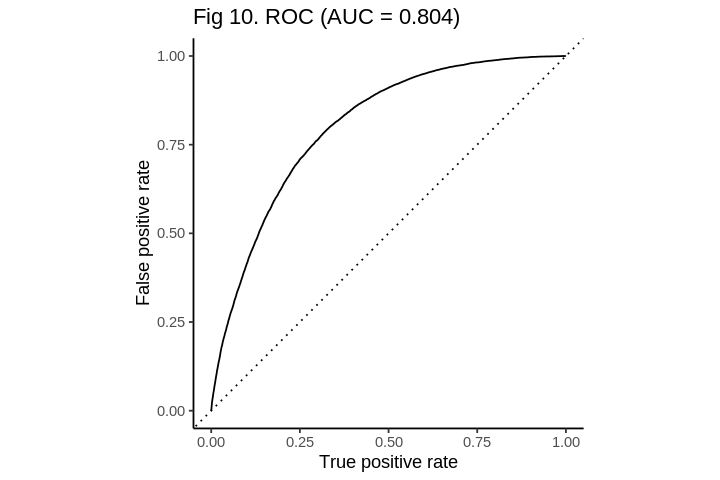

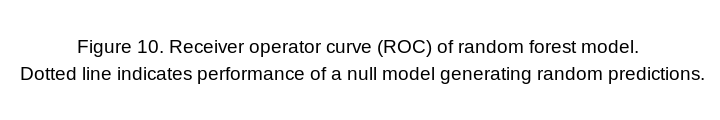

In [20]:
# ROC curve plot
options(repr.plot.width = 6, 
        repr.plot.height = 4)
auc_val <- rf_prob %>% 
  roc_auc(truth = diabetes_binary, .pred_Case) %>%
  select(.estimate) %>%
  pull() %>%
  round(digits = 3)

rf_prob %>%
  roc_curve(truth = diabetes_binary, .pred_Case) %>%
  autoplot() +
  labs(x = 'True positive rate', 
       y = 'False positive rate') +
  ggtitle(paste('Fig 10. ROC (AUC = ', auc_val, ')', sep = '')) +
  theme(text = element_text(size = 12)) +
  theme_classic()

# Figure 10 caption
options(repr.plot.width = 6, 
        repr.plot.height = 1)
fig10 <- paste('Figure 10. Receiver operator curve (ROC) of random forest model. \n Dotted line indicates performance of a null model generating random predictions.')
ggplot() + 
  annotate("text", x = 0, y = 0, size = 4, label = fig10) + 
  theme_void()

This receiver operator curve (figure 10) represents our model's ability to differentiate between cases and controls under different thresholds of true and false positive rates. Our model achieved an AUC value of approximately 0.8, indicating that it has an good ability to distinguish between the two classes.

Lastly, we performed variable importance analysis to assess the contribution of each of the ten variables we used in making accurate predictions.


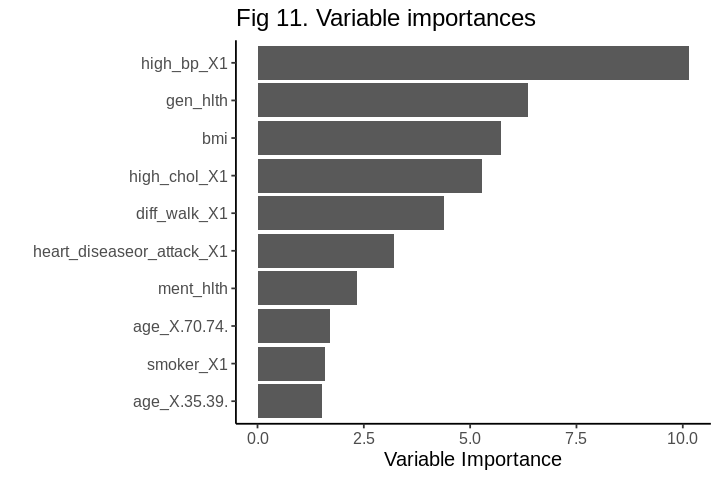

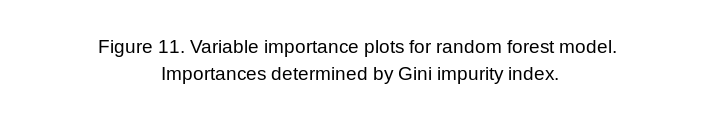

In [23]:
# Variable importance plot
options(repr.plot.width = 6, 
        repr.plot.height = 4)
rf_fit %>% 
  extract_fit_parsnip() %>% 
  vip() +
  labs(y = 'Variable Importance') +
  ggtitle('Fig 11. Variable importances') +
  theme_classic() +
  theme(text = element_text(size = 12))


# Figure 11 caption
options(repr.plot.width = 6, 
        repr.plot.height = 1)
fig11 <- paste('Figure 11. Variable importance plots for random forest model. \nImportances determined by Gini impurity index.')
ggplot() + 
  annotate("text", x = 0, y = 0, size = 4, label = fig11) + 
  theme_void()

The three most important variables in determinining predictions in our random forest model are, in order, whether the respondent had a history of high blood pressure, their self-reported general health score, and their BMI.

## 3. Discussion
Diabetes poses a substantial public health challenge in North America. Predictive models for diabetes potentially hold great promise in identifying individuals at risk of developing diabetes, enabling the implementation of targeted preventive strategies and additional diagnostic testing. In this project, we constructed a random forest model utilizing survey data obtained from the Center for Disease Control to predict the occurence of diabetes. Exhibiting an accuracy of over 70%, our model identified high blood pressure, BMI, and self-reported general health score as the top three variables crucial in shaping its predictions.

The limitations of our data analysis includes our classification model, random forest, which tends to be biased towards continuous variables rather than factored variables; due to our BMI containing continuous numerical data, our classifier will put more importance on the BMI data rather than our factored data because of this bias, thus the accuracy of this classifier might not represent the actual accuracy and and might be different from the actual variable that has the highest predictive power. Additionally, we have GenHlth as the second most influential predictor. This predictor is likely to acquire some noise due to self-reporting bias; this causes respondents to rate themselves either higher or lower than their actual general health, or also opt to answer at a neutral rate. 

Our findings can influence future research on predicting diabetes, and hopefully help other researchers acquire more accurate findings and create a more robust classifier that is more accurate to ensure that any potential diabetes diagnosis is detected and immediately accommodate those who potentially have diabetes. These findings can also provide general useful information to those who currently have sedentary lifestyles, and our visualizations can pose as infographics to guide people to take action on diabetes prevention and care.

We question the possibility of creating a more robust and accurate classifier that identifies which predictor contains the highest predictive power given the clinical and demographic data used; if the model can be more refined to determine how to differentiate between diabetes subtypes, and whether there are predictive variables associated between those subtypes.

## 4. References
Source Dataset:
https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_binary_5050split_health_indicators_BRFSS2015.csv 

https://rstudio-pubs-static.s3.amazonaws.com/802290_cb734d1218864fd093bdcf69208bd21a.html#3_Try_a_different_algorithm

https://www.diabetes.ca/about-diabetes/what-is-diabetes
